<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/IFR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESTRATÉGIA
1.   IFR para 2 períodos < 5 compra na abertura seguinte
2.   Preço fechamento > ma5 vende na abertura seguinte



In [1]:
# @ Data é ano/mes/dia.

inicio  = '2020-01-02'  #@param {type:"date"}
termino = '2022-11-30'  #@param {type:"date"}


usar_periodo = True #@param {type:"boolean"}
periodo = '1y' #@param ['1d','5d','1mo','3mo','6mo','1y','2y','3y','5y','10y','ytd','max']

In [ ]:
# @ markdown Instala bibliotecas

import pandas as pd
import numpy as np

!pip install -q pyfolio
import pyfolio as pf
!pip install -q quantstats
import quantstats as qs

!pip install -q  yfinance
import yfinance as yf

import empyrical


In [3]:
# @ markdown ## tickers das ações para rastreio
## no caso, os papeis que compôem o indice IBrA

#IBrA
codigos = ['RRRP3', 'TTEN3', 'ABCB4', 'AERI3', 'AESB3', 'ALSO3', 'AALR3', 'ALPA4', 
           'ALUP11', 'ABEV3', 'AMBP3', 'AMER3', 'ANIM3','ARZZ3', 'ARML3', 'ASAI3', 
           'AURE3', 'AZUL4', 'B3SA3', 'BPAN4', 'BRSR6', 'BBSE3', 'BMOB3', 'BLAU3', 
           'BOAS3', 'BRML3', 'BRPR3', 'BBDC3', 'BBDC4', 'BRAP3', 'BRAP4', 'BBAS3', 
           'AGRO3', 'BRKM5', 'BRFS3', 'BPAC11', 'CXSE3', 'CAML3', 'CRFB3','CBAV3', 
           'CCRO3', 'CEAB3', 'CMIG3', 'CMIG4', 'CIEL3', 'CLSA3', 'COGN3', 'CSMG3', 
           'CPLE3', 'CPLE6', 'CSAN3', 'CPFE3', 'CMIN3', 'CURY3', 'CVCB3', 'CYRE3', 
           'DASA3', 'DESK3', 'DXCO3', 'PNVL3', 'DIRR3', 'DMMO3', 'ECOR3', 'ELET3', 
           'ELET6', 'EMBR3', 'ENAT3', 'ENBR3', 'ENGI11', 'ENEV3', 'EGIE3', 'ENJU3', 
           'EQTL3', 'ESPA3', 'EVEN3', 'EZTC3', 'FHER3', 'FESA4', 'FLRY3', 'GFSA3', 
           'GGBR4', 'GOAU4', 'GETT11', 'GOLL4', 'GGPS3', 'GRND3', 'GMAT3', 'NTCO3', 
           'SBFG3', 'SOMA3', 'GUAR3', 'HAPV3', 'HBOR3', 'HBSA3', 'HYPE3', 'IGTI11', 
           'PARD3', 'MEAL3', 'IFCM3', 'INTB3', 'MYPK3', 'RANI3', 'IRBR3', 'ITSA4', 
           'ITUB3', 'ITUB4', 'JALL3', 'JBSS3', 'JHSF3', 'KEPL3', 'KLBN11', 'LAVV3', 
           'LIGT3', 'RENT3', 'LWSA3', 'LOGG3', 'LOGN3', 'AMAR3', 'LREN3', 'MDIA3', 
           'MGLU3', 'POMO4', 'MRFG3', 'MATD3', 'CASH3', 'LEVE3', 'MILS3', 'BEEF3', 
           'MODL11', 'MOVI3', 'MRVE3', 'MLAS3', 'MULT3', 'NEOE3', 'NGRD3', 'OPCT3', 
           'ODPV3', 'MEGA3', 'ONCO3', 'ORVR3', 'PCAR3', 'PGMN3', 'PETR3', 'PETR4', 
           'RECV3', 'PRIO3', 'PETZ3', 'PSSA3', 'PTBL3', 'POSI3', 'QUAL3', 'LJQQ3', 
           'RADL3', 'RAIZ4', 'RAPT4', 'RCSL3', 'RDOR3', 'ROMI3', 'RAIL3', 'SBSP3', 
           'SAPR11', 'SANB11', 'STBP3', 'SMTO3', 'SEQL3', 'SEER3', 'CSNA3', 'SIMH3', 
           'SQIA3', 'SLCE3', 'SMFT3', 'SULA11', 'SUZB3', 'SYNE3', 'TAEE11', 'TASA4', 
           'TRAD3', 'TECN3', 'TGMA3', 'VIVT3', 'TEND3', 'TIMS3', 'TOTS3', 'TRPL4', 
           'TRIS3', 'TUPY3', 'UGPA3', 'UNIP6', 'USIM3', 'USIM5', 'VALE3', 'VLID3', 
           'VAMO3', 'VIIA3', 'VBBR3', 'VIVA3', 'VULC3', 'WEGE3', 'WIZS3', 'YDUQ3']

codigos = np.array(sorted(codigos),dtype=np.object_)

In [4]:
# @ markdown ## download dados do yahoo finance
## a ultima lina da tabela tem a data mais recente
df=pd.DataFrame()
if usar_periodo : 
  df = yf.download(tickers=(codigos+'.SA').tolist(), period = periodo   , auto_adjust=True, progress = False )[['Open','Close']]
else: 
  df = yf.download(tickers=(codigos+'.SA').tolist(), start = inicio , end = termino , auto_adjust=True, progress = False )[['Open','Close']]

d = dict(zip(df.columns.levels[1],df.columns.levels[1].str.rstrip('.SA') ))
df = df.rename(columns=d, level=1)

df.columns = [" ".join(col).strip() for col in df.columns.values]
df.head(1) #mostra a primeiro linha da tabela dos preços

,Open AALR3,Open ABCB4,Open ABEV3,Open AERI3,Open AESB3,Open AGRO3,Open ALPA4,Open ALSO3,Open ALUP11,Open AMAR3,...,Close VAMO3,Close VBBR3,Close VIIA3,Close VIVA3,Close VIVT3,Close VLID3,Close VULC3,Close WEGE3,Close WIZS3,Close YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27 00:00:00-03:00,15.89,14.691876,14.306209,6.058916,11.587484,22.282875,28.98,21.871318,23.49884,3.42,...,11.659898,21.416086,4.62,25.056847,45.534309,9.123565,8.783242,31.832209,7.31632,21.358191


In [5]:
# @ markdown  função que calcula o ifr a partir de uma serie de preços

def rsi(price, window=2):   
  '''
    calcula o ifr 
    "price" é uma série de preços
    "window" é o periodo da janela móvel de obeservação, por default vale 2       
    Referencia: https://seekingalpha.com/article/4518407-rsi-indicator-meaning-and-calculation 
  '''
    
  data = pd.DataFrame(price).copy()
    
  data["Variation"] = data.diff()

  data["Gain"] = np.where(data["Variation"] > 0, data["Variation"], 0)
  data["Loss"] = np.where(data["Variation"] < 0, data["Variation"], 0)

  initial_avg_gain = data["Gain"].rolling(window).mean()
  initial_avg_loss = data["Loss"].abs().rolling(window).mean()

  avg_gain = initial_avg_gain
  avg_loss = initial_avg_loss
  for i in range(window, len(avg_gain)):
     avg_gain.iloc[i] = (avg_gain.iloc[i - 1] * (window - 1) + data["Gain"].iloc[i]) / window
     avg_loss.iloc[i] = (avg_loss.iloc[i - 1] * (window - 1) + data["Loss"].abs().iloc[i]) / window
  rsi = 100 - (100 / (1 + ( avg_gain / avg_loss )))
  return rsi

################################################################

#biblioteca *pronta* para o ifr
!pip install -q  pandas_ta
import pandas_ta as pta

**lista os ativos do índice com ifr2 < 5**


In [6]:
IFR = pd.DataFrame({f"{i}": rsi( df['Close '+i] , 2)  for i in codigos})

print('o ultimo preço é do dia',IFR.index[-1].day,'/',IFR.index[-1].month,'/',IFR.index[-1].year)
print('Os ativos com IFR<5 são:')
## seleciona os ativos dentre 'codigos' com ifr2 < 5 
lista_ifr=[]
for x in codigos :
  if IFR[x].iloc[-1]< 5 :  
    print(x)
    lista_ifr.append(x)

if len(lista_ifr)==0: print('Não tem papel com IFR<5')

o ultimo preço é do dia 27 / 1 / 2023
Os ativos com IFR<5 são:
BRPR3
MRFG3


**histórico da estratégia**

In [7]:
# @ markdown Simula as operações
def trades (x):
  '''
  'trades' cria duas listas 'entrada' e 'saida' 
  essas listas têm 3 componentes: 
    a linha na tabela de dados do sinal de entrada/saida;
    a data seguinte do sinal (entrada/saida) e 
    o preço (open) de entrada/saida naquele dia
  '''
  open  = 'Open '+x
  close = 'Close '+x

  bt = df[[open , close]].copy() 
  #media movel simples de 5 periodos 
  bt['mm5'] = df[close].rolling(5).mean()  
  bt['ifr'] = IFR[x]
  bt=bt.dropna()

  ## marca todos os pontos com ifr2 < 5
  bt['sinal_entra'] = np.where(bt['ifr'] < 5 , 1 , 0)
  #marca todos pontos com close > mm5
  bt['sinal_sai'] = np.where(bt[close] > bt['mm5'] , -1 , 0)

  '''
  cria listas com os pontos de entrada e saída das operações
  1) percorre a tabela bt em ordem cronológica até achar sinal entrada
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de abertura do dia seguinte
  2) em seguida, continua, a partir do proximo dia, até achar sinal saida
     quando acha, armazenas as informações: 
       linha da tabela, data do sinal e preço de fechamento do dia seguinte
  3) repete os passos 1 e 2 
  '''  
  entrada = []
  saida = []
  i=0
  while i < len(bt):
    while bt['sinal_entra'][i] == 0 : i+=1      #pega um sinal de entrada
    if i+1 < len(bt) :                          #se teve pregão dia seguinte,entra
        i+=1
        entrada.append( ( i-1, 
                         bt.index[i].date().strftime("%d/%m/%Y") , 
                         np.round(bt[open].iloc[i],2)))  
       #avança até o primeiro sinal de saída, que pode ser no proprio dia
        while (i < len(bt) and bt['sinal_sai'].iloc[i]==0) : i=i+1    
       #se teve pregão dia seguinte,sai  
        if i+1 < len(bt) :  
            i+=1
            saida.append( (i-1, 
                           bt.index[i].date().strftime("%d/%m/%Y")  , 
                           np.round(bt[open].iloc[i],2)) )  
            # senão, a ultima operação ainda não deu saida 
        else : entrada.pop()                    
    i=i+1
  return entrada,saida

In [25]:
# @ markdown Mostra os resultados

resumo = pd.DataFrame(index=lista_ifr,columns=['IFR2', 'Operações' , 'Retornos positivos' , 'Tx acerto' , 'Acumulado', 'Retorno médio' , 'Duração média(dias)' ])

# usando as informações da função 'trades', simula as operações
# calcula o tempo de cada operação e a variação do preço do ativo

out =  [ [[],[]] for j in range(len(lista_ifr))] 
retornos = [ [[],[]] for j in range(len(lista_ifr))] 
z=0
for x in lista_ifr:
  dura = []  ## duração da operação, em dias uteis
  e    = []  ## pontos de entrada 
  s    = []  ## pontos de saida
  posret = 0 ## conta retornos positivos

  e,s = trades(x)
  # mensagens para ajudar na validação
  out1 =  ['' for j in range(len(e))] 
  out2 =  ['' for j in range(len(e))] 
  out3 =  ['' for j in range(len(e))] 
  for j in range(len(e)) :
      out1[j] =  "entrada em " + str(e[j][1]) + " e saida em " + str(s[j][1]) 
      
      dias = s[j][0] - e[j][0]
      out2[j] = " durou "+str(dias)+" dias e "
      dura.append(dias)

      retorno = s[j][2]/e[j][2] - 1
      out3[j] = "variou "+str(round(retorno*100,3))+"%" 
      retornos[z][1].append(retorno)
      if retorno > 0 : posret +=1
  
  resumo.loc[x] = [ IFR[x][-1].round(2), len(e) , posret , np.round(posret/len(e),3) , #
                   np.round((np.array(retornos[z][1])+1).cumprod()[-1] - 1,2) , #
                   np.round(np.mean(retornos[z][1])*100,2) , np.round(np.mean(dura),1) ]
  
  retornos[z][0] = x
  out[z][0] = x
  for j in range(len(e)) : 
        out[z][1].append(out1[j] + out2[j]+out3[j])        
  z=z+1

resumo.sort_values(by=['Tx acerto'], ascending=False)

,IFR2,Operações,Retornos positivos,Tx acerto,Acumulado,Retorno médio,Duração média(dias)
BRPR3,2.75,5,4,0.8,0.57,10.39,3.2
MRFG3,4.74,9,4,0.444,-0.27,-3.12,5.3


In [9]:
for x in range(len(lista_ifr)):
  print("\n******",retornos[x][0],"********")
  print('resumo dos retornos das operações:')
  print(pd.Series(retornos[x][1]).describe()  );


****** BRPR3 ********
resumo dos retornos das operações:
count    5.000000
mean     0.103897
std      0.173338
min     -0.016129
25%      0.009732
50%      0.020797
75%      0.101190
max      0.403893
dtype: float64

****** MRFG3 ********
resumo dos retornos das operações:
count    9.000000
mean    -0.031231
std      0.078743
min     -0.159200
25%     -0.085161
50%     -0.052480
75%      0.043217
max      0.073293
dtype: float64


In [26]:
out

[['BRPR3',
  ['entrada em 08/03/2022 e saida em 10/03/2022 durou 2 dias e variou 10.119%',
   'entrada em 08/07/2022 e saida em 14/07/2022 durou 4 dias e variou -1.613%',
   'entrada em 31/08/2022 e saida em 02/09/2022 durou 2 dias e variou 0.973%',
   'entrada em 27/09/2022 e saida em 29/09/2022 durou 2 dias e variou 40.389%',
   'entrada em 11/11/2022 e saida em 22/11/2022 durou 6 dias e variou 2.08%']],
 ['MRFG3',
  ['entrada em 03/02/2022 e saida em 09/02/2022 durou 4 dias e variou 0.868%',
   'entrada em 25/04/2022 e saida em 28/04/2022 durou 3 dias e variou 4.725%',
   'entrada em 05/05/2022 e saida em 16/05/2022 durou 7 dias e variou -5.248%',
   'entrada em 15/06/2022 e saida em 24/06/2022 durou 6 dias e variou -5.375%',
   'entrada em 19/07/2022 e saida em 20/07/2022 durou 1 dias e variou 7.329%',
   'entrada em 29/08/2022 e saida em 16/09/2022 durou 13 dias e variou -15.92%',
   'entrada em 26/09/2022 e saida em 05/10/2022 durou 7 dias e variou -10.293%',
   'entrada em 23/11

# daqui pra baixo são testes de códigos

In [11]:
# cria uma tabela com o ifr2 do pandas_ta
IFR2 = pd.DataFrame({f"{i}": pta.rsi( df['Close '+i] , 2)  for i in codigos})
IFR2.tail(1)

,AALR3,ABCB4,ABEV3,AERI3,AESB3,AGRO3,ALPA4,ALSO3,ALUP11,AMAR3,...,VAMO3,VBBR3,VIIA3,VIVA3,VIVT3,VLID3,VULC3,WEGE3,WIZS3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-27 00:00:00-03:00,10.777918,57.798831,38.762807,63.005931,91.613584,37.915429,23.044196,32.815444,17.105931,56.511083,...,92.877134,86.848793,28.5024,99.737206,61.087702,75.452041,17.829147,38.992344,67.290949,20.613306


In [79]:
IFR.tail(1)

,AALR3,ABCB4,ABEV3,AERI3,AESB3,AGRO3,ALPA4,ALSO3,ALUP11,AMAR3,...,VAMO3,VBBR3,VIIA3,VIVA3,VIVT3,VLID3,VULC3,WEGE3,WIZS3,YDUQ3
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-27 00:00:00-03:00,10.777918,57.798831,38.762807,63.005931,91.613584,37.915429,23.044196,32.815444,17.105931,56.511083,...,92.877134,86.848793,28.5024,99.737206,61.087702,75.452041,17.829147,38.992344,67.290949,20.613306


In [80]:
x='BRPR3'
open  = 'Open '+x
close = 'Close '+x

bt = df[[open , close]].copy() 
bt['ret'] = np.log(df[close]/df[close].shift(1)) 
bt['mm5'] = df[close].rolling(5).mean()  #media movel simples de 5 periodos 
bt['ifr'] = IFR2[x]
bt=bt.dropna()


In [81]:
## marca todos os pontos com ifr2 < 5
bt['sinal_entra'] = np.where(bt['ifr'] < 5 , 1 , 0)
  #marca todos pontos com close > mm5
bt['sinal_sai']   = np.where(bt[close] > bt['mm5'] , 1 , 0)

In [ ]:
bt

In [82]:
bt['posicao']=0 #df['posicao'] = pd.Series([1 for x in range(len(bt.index))])

In [83]:
entrada = []
saida = []
i=0
while i < len(bt):
  while bt['sinal_entra'][i] == 0 : i+=1      #pega um sinal de entrada
  #se teve pregão dia seguinte,entra
  if i+1 < len(bt) :      
    i+=1
    bt['posicao'].iloc[i] = 1
    entrada.append( ( i-1,                                      # sinal
                      bt.index[i].date().strftime("%d/%m/%Y") ,  # data entrada
                      np.round(bt[open].iloc[i],2)))             # preço entrada
     #avança até o primeiro sinal de saída, que pode ser no proprio dia
    while (i < len(bt) and bt['sinal_sai'].iloc[i]==0) : 
      bt['posicao'].iloc[i] = 1
      i=i+1    
    bt['posicao'].iloc[i] = 1
    #se teve pregão dia seguinte,sai  
    if i+1 < len(bt) :  
      i+=1
      saida.append( (i-1,                                       # sinal
                     bt.index[i].date().strftime("%d/%m/%Y")  , # data saida
                     np.round(bt[open].iloc[i],2)) )            # preço saida
    # senão, a ultima operação ainda não deu saida 
    else : entrada.pop()                    
  i=i+1


In [84]:
bt[bt.index.month==7]

,Open BRPR3,Close BRPR3,ret,mm5,ifr,sinal_entra,sinal_sai,posicao
Date,,,,,,,,
2022-07-01 00:00:00-03:00,4.431764,4.421772,0.000000,4.404784,88.521394,0,1,0
2022-07-04 00:00:00-03:00,4.406782,4.411779,-0.002262,4.413777,42.043255,0,0,0
2022-07-05 00:00:00-03:00,4.411778,4.401786,-0.002268,4.412778,20.507407,0,0,0
2022-07-06 00:00:00-03:00,4.391793,4.381801,-0.004551,4.407782,6.726331,0,0,0
2022-07-07 00:00:00-03:00,4.496716,4.341829,-0.009164,4.391793,1.823801,1,0,0
2022-07-08 00:00:00-03:00,4.341829,4.296863,-0.010411,4.366811,0.690863,1,0,1
2022-07-11 00:00:00-03:00,4.256892,4.221917,-0.017596,4.328839,0.224987,1,0,1
2022-07-12 00:00:00-03:00,4.196935,4.281873,0.014101,4.304857,52.006730,0,0,1
2022-07-13 00:00:00-03:00,4.291866,4.296863,0.003495,4.287869,61.894944,0,1,1


In [85]:
bt.head()

,Open BRPR3,Close BRPR3,ret,mm5,ifr,sinal_entra,sinal_sai,posicao
Date,,,,,,,,
2022-02-02 00:00:00-03:00,3.530411,3.471159,-0.014125,3.530411,11.188766,0,0,0
2022-02-03 00:00:00-03:00,3.481035,3.550161,0.022505,3.530411,68.170451,0,1,0
2022-02-04 00:00:00-03:00,3.584725,3.589662,0.011065,3.541273,80.610662,0,1,0
2022-02-07 00:00:00-03:00,3.579787,3.639039,0.013661,3.554111,90.193028,0,1,0
2022-02-08 00:00:00-03:00,3.629163,3.574849,-0.017796,3.564974,39.472783,0,1,0


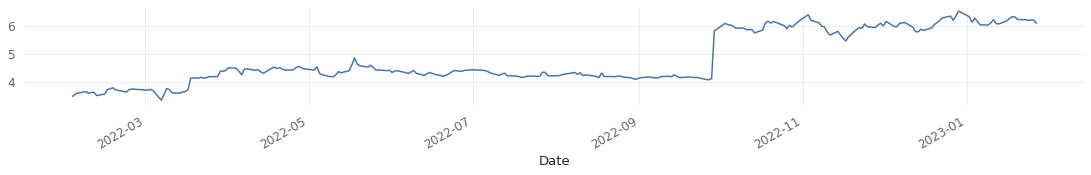

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
bt['Close BRPR3'].plot(figsize=(19,2));

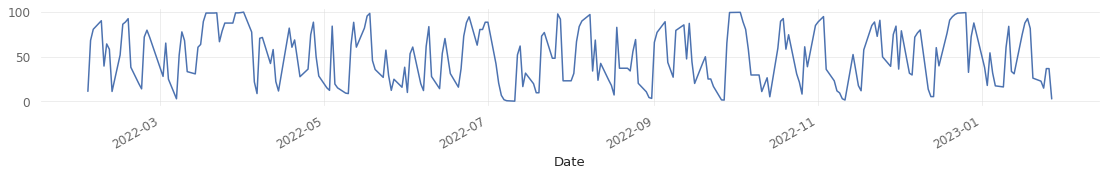

In [88]:
bt['ifr'].plot(figsize=(19,2));

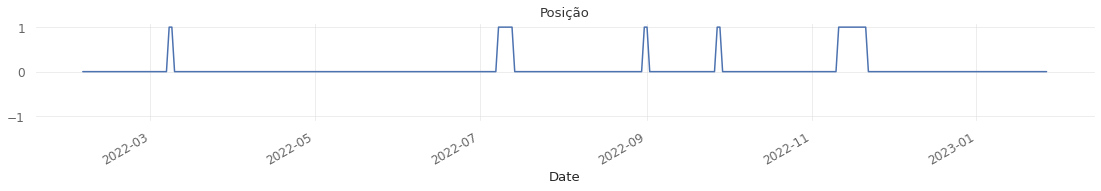

In [98]:
bt['posicao'].plot(ylim=[-1.1, 1.1],title='Posição',figsize=(19,2));

In [90]:
## calculating stretegy returns
bt['strategy_returns'] = bt['ret'] * (bt['posicao'].shift(1))
bt['strategy_returns'].iloc[0]=0
bt

,Open BRPR3,Close BRPR3,ret,mm5,ifr,sinal_entra,sinal_sai,posicao,strategy_returns
Date,,,,,,,,,
2022-02-02 00:00:00-03:00,3.530411,3.471159,-0.014125,3.530411,11.188766,0,0,0,0.0
2022-02-03 00:00:00-03:00,3.481035,3.550161,0.022505,3.530411,68.170451,0,1,0,0.0
2022-02-04 00:00:00-03:00,3.584725,3.589662,0.011065,3.541273,80.610662,0,1,0,0.0
2022-02-07 00:00:00-03:00,3.579787,3.639039,0.013661,3.554111,90.193028,0,1,0,0.0
2022-02-08 00:00:00-03:00,3.629163,3.574849,-0.017796,3.564974,39.472783,0,1,0,-0.0
...,...,...,...,...,...,...,...,...,...
2023-01-23 00:00:00-03:00,6.230000,6.220000,-0.001606,6.274000,22.582022,0,0,0,-0.0
2023-01-24 00:00:00-03:00,6.240000,6.200000,-0.003221,6.260000,14.797646,0,0,0,-0.0
2023-01-25 00:00:00-03:00,6.240000,6.210000,0.001612,6.236000,36.639515,0,0,0,0.0


In [92]:
bt=bt[1:]
bt.head(1)

,Open BRPR3,Close BRPR3,ret,mm5,ifr,sinal_entra,sinal_sai,posicao,strategy_returns
Date,,,,,,,,,
2022-02-04 00:00:00-03:00,3.584725,3.589662,0.011065,3.541273,80.610662,0,1,0,0.0


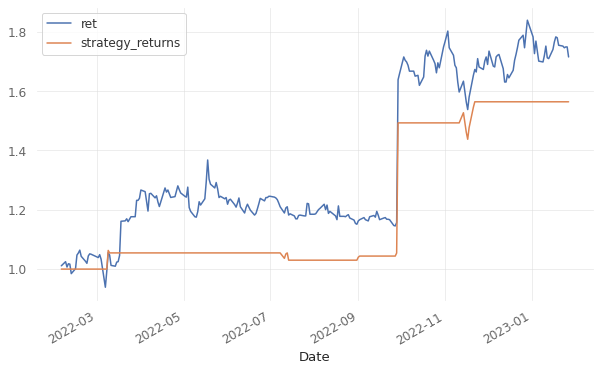

In [102]:
bt[['ret', 'strategy_returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [94]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("B&H retorno:",bt['ret'].cumsum()[-1])
print("Estratégia retorno:",bt['strategy_returns'].cumsum()[-1])


Buy and hold returns: 0.5396550503245616
Strategy returns: 0.4473731731193127


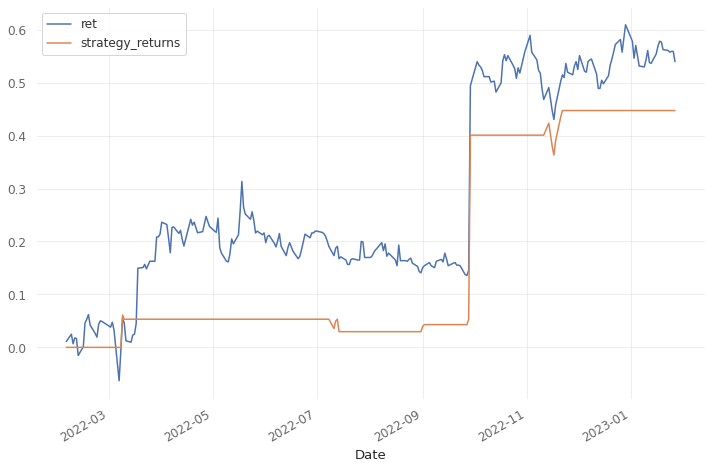

In [96]:
dD = pd.DataFrame()
# plotting strategy historical performance over time
dD[['ret','strategy_returns']] = bt[['ret','strategy_returns']].cumsum()
dD[['ret','strategy_returns']].plot(grid=True, figsize=(12, 8))


In [104]:
empyrical.sharpe_ratio(bt['ret'])

1.1536514465926944

/usr/local/lib/python3.8/dist-packages/empyrical/stats.py:1527: RuntimeWarning:

invalid value encountered in double_scalars



Start date,2022-02-04
End date,2023-01-27
Total months,11
,Backtest
Annual return,49.5%
Cumulative returns,48.1%
Annual volatility,36.7%
Sharpe ratio,1.25
Calmar ratio,8.30
Stability,0.70
Max drawdown,-6.0%


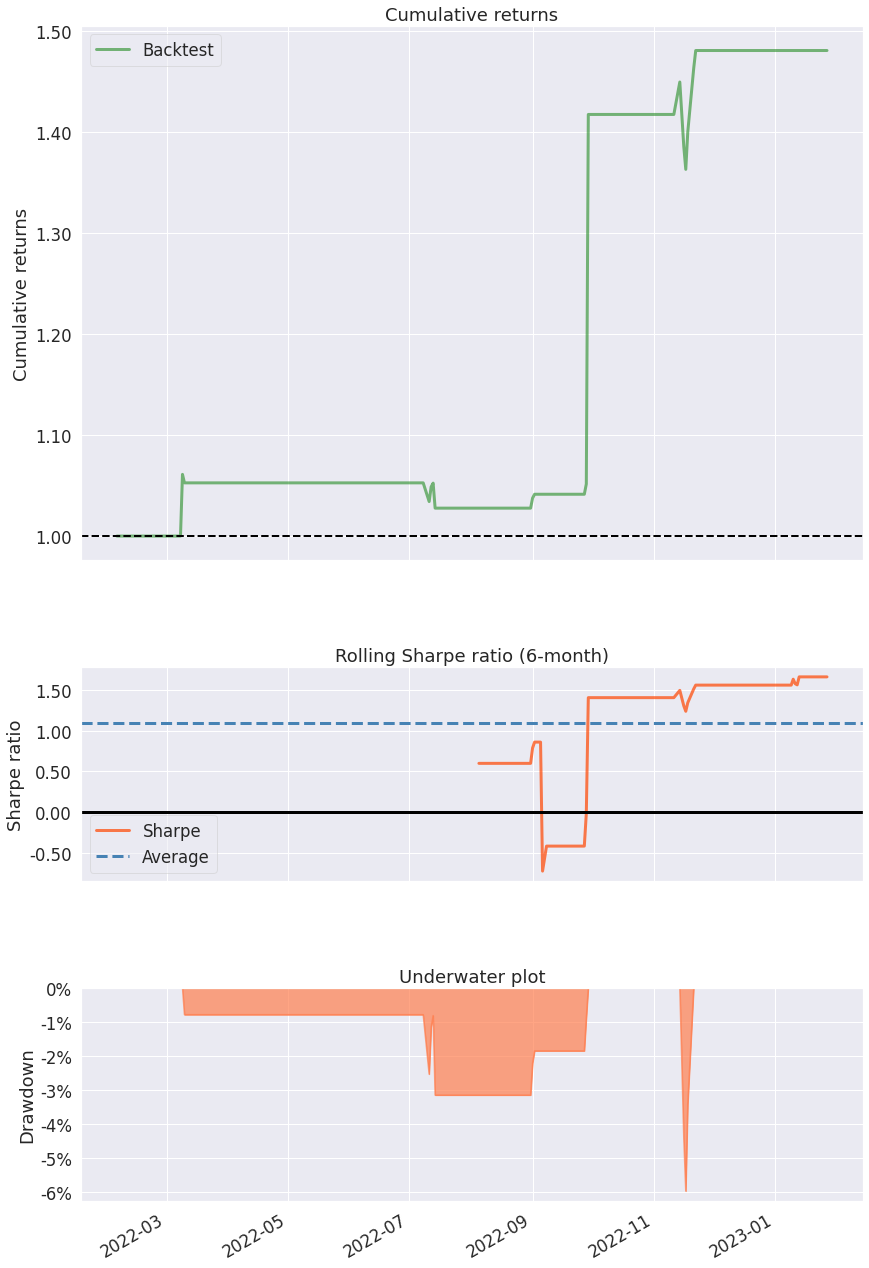

In [105]:
pf.create_simple_tear_sheet(bt['strategy_returns'])